#**TRAFFIC INCIDENT DETECTION BASED ON FACTOR ANALYSIS AND WEIGHTED RANDOM FOREST**

####Dataset: US_Accident dataset, the United States has more than four times the number of car accidents of any other country in the world.
This is a countrywide  accident dataset that covers **49 states of the USA**. The accident data were collected from **2016 to March 2023**, using multiple APIs that provide streaming traffic incident data.

###By Model Comparision and Evaluation
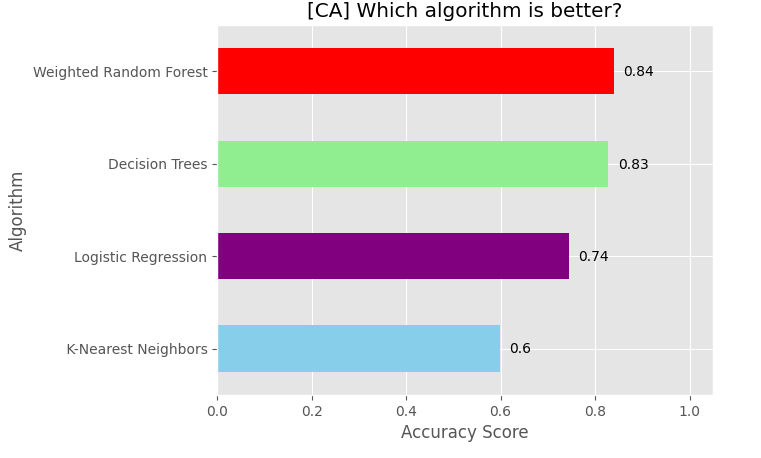

**Weighted Random Forest performs better on this dataset.**

##Import Necessary Libraries
####Importing essential libraries for data manipulation, visualization, machine learning, and geographical mapping.

In [30]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis

##Load the Dataset

In [31]:
# Load the dataset
df = pd.read_csv('Accidents.csv')

##Data Preprocessing
###Cleaning and preparing the dataset for analysis by handling missing values, converting timestamps, and extracting additional temporal features.

In [32]:
# Data Preprocessing

# Convert Start_Time and End_Time to datetimes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Drop duplicates
df = df.drop_duplicates()

# Handle missing values
# Impute missing values in numerical features with mean
numeric_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Impute missing values in categorical features with mode
categorical_cols = ['Weather_Condition']
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Convert 'Start_Time' and 'End_Time' to datetime
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])

# Extract features from 'Start_Time'
df['Hour'] = df['Start_Time'].dt.hour
df['Day'] = df['Start_Time'].dt.day
df['Month'] = df['Start_Time'].dt.month
df['Weekday'] = df['Start_Time'].dt.weekday

##Filter Data for California
###Select the state of interest: CA - CALIFORNIA

Due to the limitation of personal laptop, the whole US dataset is too big to handle

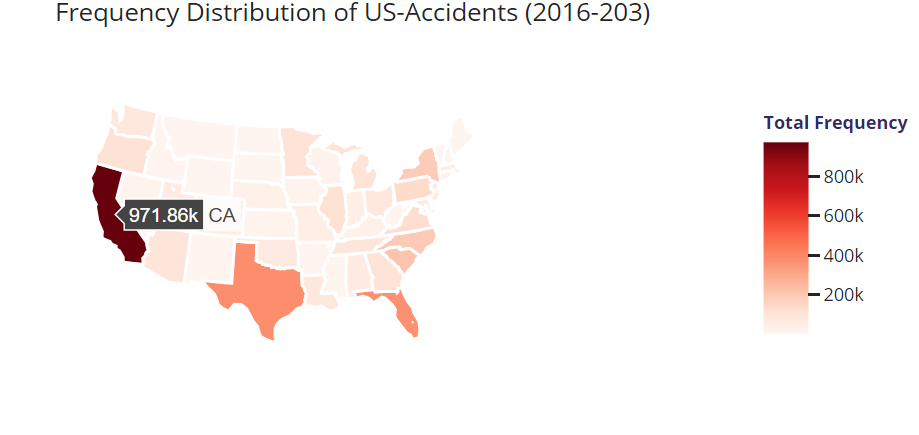

In [33]:
# Filter data for California only
df_ca = df[df['State'] == 'CA']

##Feature Engineering - Factor Analysis
###Performing factor analysis on selected numerical features to extract underlying factors, specifically related to weather conditions and day of the week.

In [34]:
# Feature Engineering: Factor Analysis

# Select numerical features for factor analysis
numeric_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)']

# Drop rows with missing values for factor analysis
df_ca_factor = df_ca[numeric_cols].dropna()

# Standardize the data
scaler = StandardScaler()
df_ca_factor_scaled = scaler.fit_transform(df_ca_factor)

# Apply Factor Analysis
n_factors = 2  # Number of factors to extract
fa = FactorAnalysis(n_components=n_factors)
fa.fit(df_ca_factor_scaled)
df_ca['Weather_Condition'] = fa.transform(df_ca[numeric_cols].values)[:, 0]
df_ca['Day'] = fa.transform(df_ca[numeric_cols].values)[:, 1]

<ipython-input-34-25df99b7a023>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['Weather_Condition'] = fa.transform(df_ca[numeric_cols].values)[:, 0]
<ipython-input-34-25df99b7a023>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['Day'] = fa.transform(df_ca[numeric_cols].values)[:, 1]


##Random Forest for Feature Importance
###Using a Random Forest classifier to identify and rank the importance of features in predicting accident severity.

In [35]:
# Random Forest for Feature Importance

# Assuming 'target' is the target variable for classification
target = 'Severity'

# Select features for random forest
feature_cols = ['Weather_Condition', 'Day', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)']

# Set the target for the prediction
y = df_ca[target]
X = df_ca[feature_cols]

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the model
clf.fit(X_train, y_train)

# Feature Importance
feature_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

##Severity Distribution Visualization
###Visualizing the distribution of accidents based on severity using a horizontal bar plot.


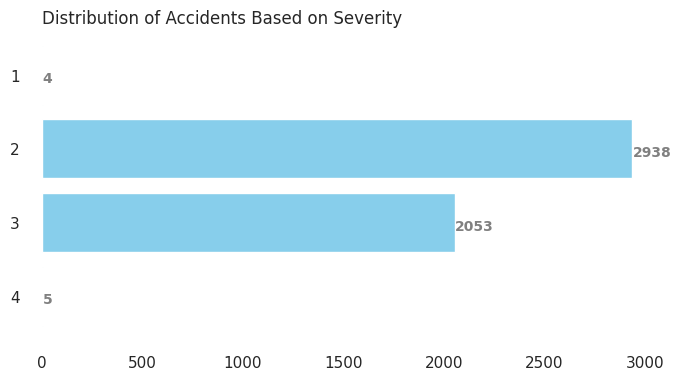

In [36]:
# Assuming you have a 'Severity' column
severity_data = df['Severity'].value_counts().sort_index()

# Figure Size
fig, ax = plt.subplots(figsize=(8, 4))

# Horizontal Bar Plot
ax.barh(severity_data.index, severity_data.values, color='skyblue')

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Set y-axis ticks without decimals
plt.yticks(range(1, len(severity_data) + 1))

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width() + 0.2, i.get_y() + 0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Distribution of Accidents Based on Severity',
             loc='left')

# Show Plot
plt.show()


##Folium Map Creation - Frequent Accident Zones
### Creating a Folium map and adding frequent accident zones and adding CircleMarkers to the map.

In [37]:
# Task 1: Display accident pro zone routes with plotlines

# Create a folium map centered around California
accident_pro_zone_map = folium.Map(location=[36.7783, -119.4179], zoom_start=12)

# Create a feature group for the accident pro zone routes (PolyLines) using openstreetmap tile
accident_pro_zone_routes = folium.FeatureGroup(name='Accident Pro Zone Routes', overlay=True, control=True)
accident_pro_zone_map.add_child(accident_pro_zone_routes)

# Create a feature group for frequent accident zones (CircleMarkers) using stamentoner tile
frequent_accident_zones = folium.FeatureGroup(name='Frequent Accident Zones', overlay=True, control=True)
accident_pro_zone_map.add_child(frequent_accident_zones)

# Plot blue lines to indicate accident pro zone routes on openstreetmap tile
for index, row in df_ca.iterrows():
    folium.PolyLine([(row['Start_Lat'], row['Start_Lng'])], color='blue', line_opacity=0.5).add_to(accident_pro_zone_routes)

# Count the frequency of accident zones
zone_frequency = df_ca.groupby(['Start_Lat', 'Start_Lng']).size().reset_index(name='Frequency')

# Define a threshold for frequent accident zones (you can adjust this threshold)
frequency_threshold = 5

# Add CircleMarkers for frequent accident zones with popup
for index, row in zone_frequency.iterrows():
    if row['Frequency'] >= frequency_threshold:
        folium.CircleMarker([row['Start_Lat'], row['Start_Lng']],
                            radius=5,
                            color='red',
                            fill=True,
                            fill_color='red',
                            popup=f"Frequent Accident Zone\nFrequency: {row['Frequency']}").add_to(frequent_accident_zones)

# Add different map tiles
folium.TileLayer('openstreetmap').add_to(accident_pro_zone_map)
folium.TileLayer('stamentoner').add_to(accident_pro_zone_map)

# Add Layer Control to switch between layers
folium.LayerControl().add_to(accident_pro_zone_map)

# Save the map with default tile layer
accident_pro_zone_map.save('accident_pro_zone_map.html')

##Display Important Features and Severity Analysis
###Displaying the top important features using a bar plot

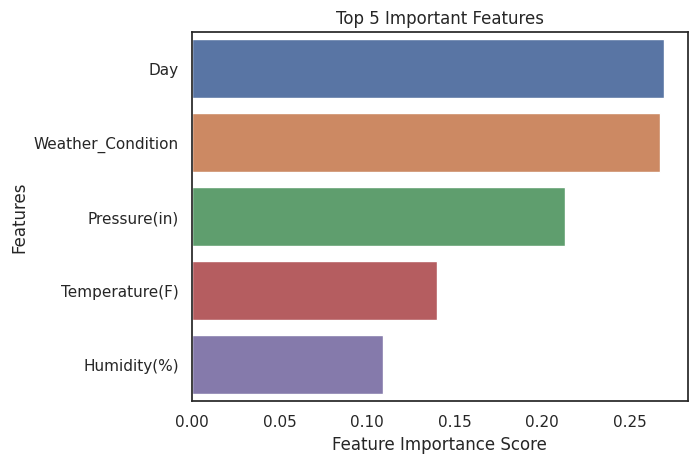

In [38]:
# Task 2: Display important features after feature selection in a graph
k = 5 # Change this based on the number of top features you want to display
sns.barplot(x=feature_imp[:k], y=feature_imp.index[:k])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top {} Important Features".format(k))
plt.show()

##Important Features vs. Severity Plots
### analyzing the relationship between important features and accident severity using box plots.

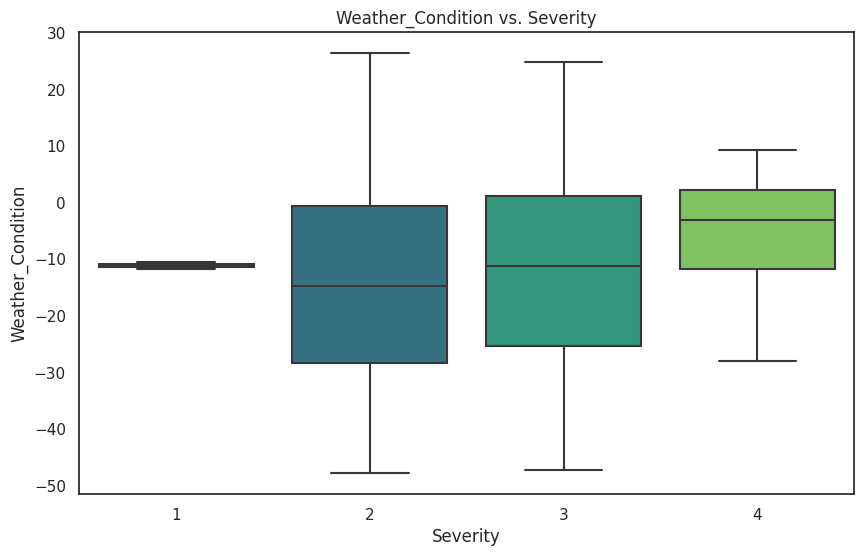

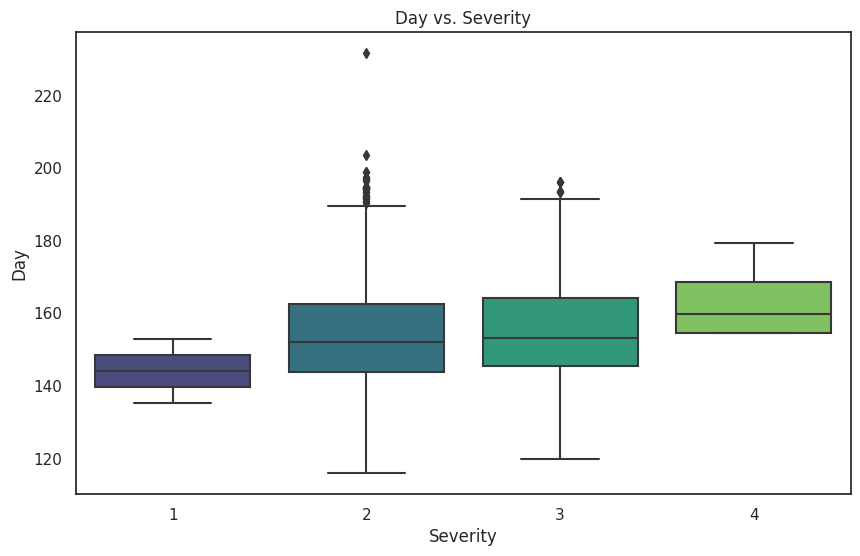

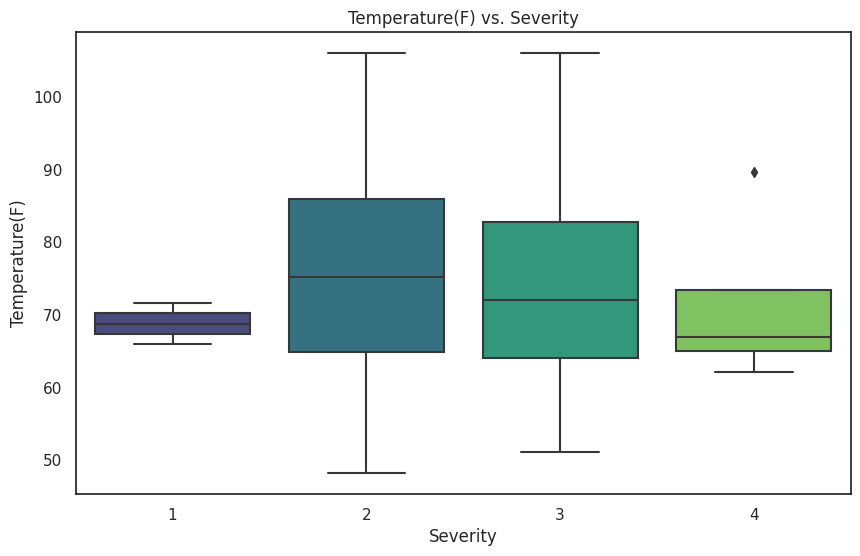

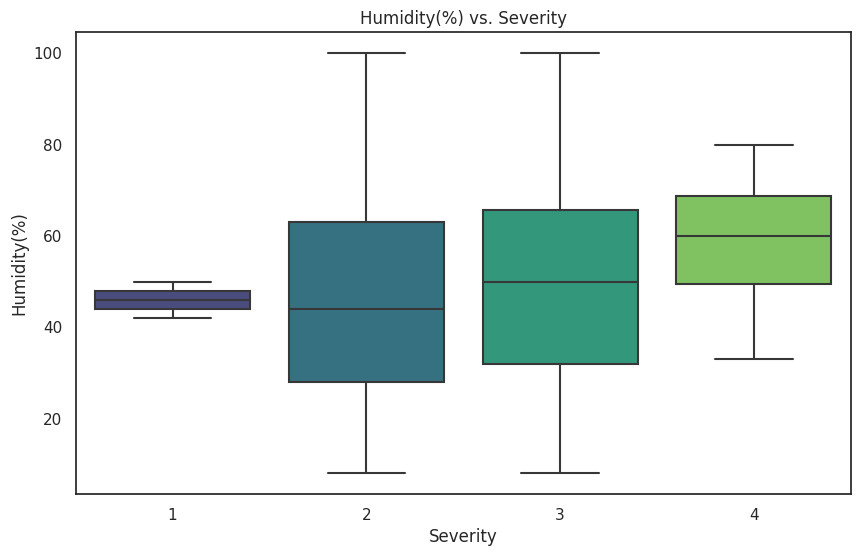

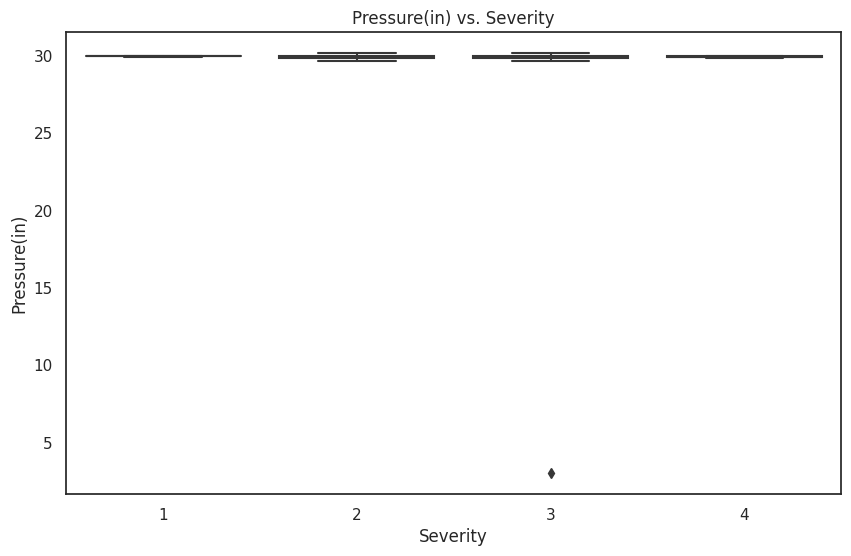

In [39]:
# Important Features vs. Severity Plots
for feature in feature_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Severity', y=feature, data=df_ca, palette='viridis')
    plt.xlabel('Severity')
    plt.ylabel(feature)
    plt.title(f'{feature} vs. Severity')
    plt.show()


##Display accident information based on user input
###Allowing user input for latitude and longitude, checking if accidents occurred at that location, and providing information or indicating no accidents. If accidents are found, a map with a marker at the specified location is created and saved.

In [40]:
# Task 3: Display accident information based on user input
print("-120.812286    37.694611")
start_lng = float(input("Enter the Start Longitude: "))
start_lat = float(input("Enter the Start Latitude: "))

# Check if accidents occurred for the provided coordinates
accidents_at_location = df_ca[(df_ca['Start_Lng'] == start_lng) & (df_ca['Start_Lat'] == start_lat)]

if not accidents_at_location.empty:
    print("Accidents found for the provided coordinates: Yes.")
    print("\nAccidents Information:")

    accidents_table = accidents_at_location[['ID','Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Hour']]

    # Display the results as a vertical table
    print("\nAccidents Information:")
    print(accidents_table.T)


    accident_location_map = folium.Map(location=[start_lat, start_lng], zoom_start=10)

    # Add a marker at the provided location
    folium.Marker([start_lat,start_lng], tooltip="Accident Location").add_to(accident_location_map)


    accident_location_map.save('accident_location.html')
    print("Accident location map saved.")

else:
    print("Accidents found for the provided coordinates: No.")

-120.812286    37.694611
Enter the Start Longitude: -120.812286
Enter the Start Latitude: 37.694611
Accidents found for the provided coordinates: Yes.

Accidents Information:

Accidents Information:
                  4364
ID              A-4365
Temperature(F)    87.1
Humidity(%)       31.0
Pressure(in)      29.8
Hour                22
Accident location map saved.


##Conclusion:

1.  **Accident Patterns**: The analysis revealed insights into accident patterns
based on weather conditions and temporal factors using Factor analysis
2.  **Accident-Prone Zones**: The map visualizations identified routes and zones with a higher frequency of accidents.
3.  **Important Features vs Severity**: Factors derived from weather conditions, along with other selected features, played a crucial role in determining accident severity using Random forest classifier.
4.  **User-Friendly Interface**: The user input module provided a practical way for individuals to accident detection and check accident information for specific locations.


